In [6]:
import pyart, tempfile, boto3, pytz
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime
from botocore.handlers import disable_signing

In [7]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x-pivot))

bucket = 'noaa-nexrad-level2'
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)   
aws_radar = s3.Bucket(bucket)

def current_radar_scan(radar_name):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    desired_datetime = datetime.utcnow() 
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key

In [8]:
radar_scan = current_radar_scan('KLOT')
print(radar_scan)

2018/06/06/KLOT/KLOT20180606_155419_V06


In [9]:
localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(radar_scan, localfile.name)
radar= pyart.io.read(localfile.name)
    

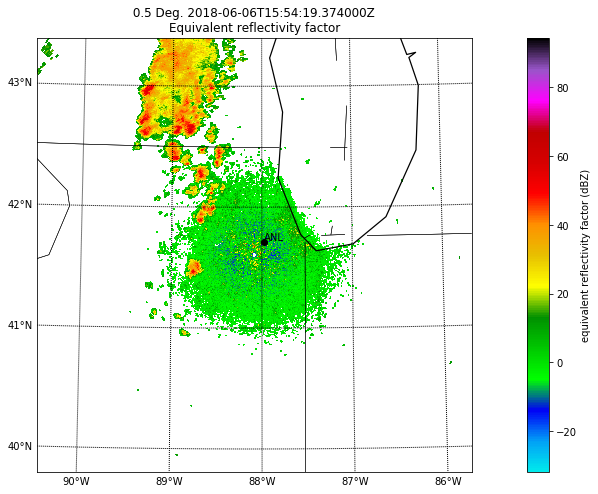

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(20,8))
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', resolution='l',
                         sweep=0, fig=fig, width=400000, height=400000)
display.plot_point(-87.981810, 41.713969 , label_text='ANL', color = 'k')
